**Initial setup**

**To use keras_vc we have to do these initial operations**

In [ ]:
! apt -y install --allow-change-held-packages libcudnn8=8.6.0.163-1+cuda11.8

In [ ]:
! pip uninstall -y tensorflow tensorflow-gpu 
! pip uninstall -y tensorflow-io
! pip uninstall -y tensorflow-transform

In [ ]:
! pip install tensorflow-transform
! pip install tensorflow==2.10.1 tensorflow-gpu==2.10.1
! pip install keras-cv --upgrade

**Libraries**

In [1]:
import tensorflow as tf
import numpy as np
from numpy import asarray
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix

from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import class_weight
import datetime 
import pathlib

import keras_cv

print('Keras_CV : ', keras_cv.__version__)
tfk = tf.keras
tfkl = tf.keras.layers
print('Tensorflow : ', tf.__version__)

2022-11-22 22:29:08.597940: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-22 22:29:08.771863: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-22 22:29:09.643269: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local

Keras_CV :  0.3.4
Tensorflow :  2.10.1


In [2]:
seed = 42127
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

### Suppress warnings

In [3]:
import warnings
import logging

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)
tf.get_logger().setLevel('INFO')
tf.autograph.set_verbosity(0)

tf.get_logger().setLevel(logging.ERROR)
tf.get_logger().setLevel('ERROR')
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# **Dataset preparation**

In [4]:
imbalClasses = tf.keras.utils.image_dataset_from_directory( 
    '/kaggle/input/dataset-1and6/only1and6',
    labels='inferred',
    label_mode='categorical',
    class_names=None,
    color_mode='rgb',
    batch_size=32,
    image_size=(96,96),
    subset = 'training',
    validation_split=0.15,
    seed=seed,
)

Found 414 files belonging to 8 classes.
Using 352 files for training.


2022-11-22 22:29:21.258515: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-22 22:29:21.272404: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-22 22:29:21.273178: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-22 22:29:21.274303: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [5]:
AUTOTUNE = tf.data.AUTOTUNE
datapath = '/kaggle/input/dataset/training_data_final'
training_set = tf.keras.utils.image_dataset_from_directory(
    datapath,
    labels='inferred',
    label_mode='categorical',
    color_mode='rgb',
    image_size=(96,96),
    shuffle=True,
    seed=seed,
    validation_split=0.15,
    subset='training'
)

validation_set = tf.keras.utils.image_dataset_from_directory(
    datapath,
    labels='inferred',
    label_mode='categorical',
    color_mode='rgb',
    image_size=(96,96),
    shuffle=True,
    seed=seed,
    validation_split=0.15,
    subset='validation'
)


Found 3542 files belonging to 8 classes.
Using 3011 files for training.
Found 3542 files belonging to 8 classes.
Using 531 files for validation.


# **Dataset augmentation**

**Augmenter** 

**We build this Augmenter, made of three layers: a generic augmentation layer (implemented with keras_cv layer RandAugment), a CutMix layer and a MixUp layer.**

In [9]:

augmenter = keras_cv.layers.Augmenter( 
  layers=[
      keras_cv.layers.RandAugment( 
        value_range=(0, 255),
        augmentations_per_image=3,
        magnitude=0.3,
        magnitude_stddev=0.2,
        rate=0.5,),
      keras_cv.layers.CutMix(),
      keras_cv.layers.MixUp()
    ]
)

def augment_data(images, labels):
    inputs = {"images": images, "labels": labels}
    outputs = augmenter(inputs)
    return outputs['images'], outputs['labels']


**Now we do the actual augmentation**

**As usual, we first do the selective augmentation on classes 1 and 6 and then the total augmentation on the training set**

In [10]:
dataAugmImbal = imbalClasses.map(augment_data, num_parallel_calls=tf.data.AUTOTUNE) 
dataAugmImbal = dataAugmImbal.concatenate(imbalClasses.map(augment_data, num_parallel_calls=tf.data.AUTOTUNE))

In [11]:
training_set = training_set.concatenate(training_set.map(augment_data, num_parallel_calls=tf.data.AUTOTUNE) ) #total augm
training_set = training_set.concatenate(dataAugmImbal)
training_set = training_set.concatenate(imbalClasses) #OVERSAMPLING classes 1 and 6 

In [12]:
training_set = training_set.cache().shuffle(buffer_size=1000).prefetch(buffer_size=AUTOTUNE)
validation_set = validation_set.cache().prefetch(buffer_size=AUTOTUNE)

**Preprocessing**

In [13]:
training_set = training_set.map(lambda x,y: (tf.keras.applications.inception_v3.preprocess_input(x), y))
validation_set = validation_set.map(lambda x,y: (tf.keras.applications.inception_v3.preprocess_input(x),y))

# **Network**

In [14]:
myInception = tfk.applications.inception_v3.InceptionV3(include_top = False, weights='imagenet')

In [15]:
myInception.trainable = True


In [16]:
input_shape = (96, 96, 3)
epochs = 100

l1 = 0.001
l2 = 0.001
dropout_rate = 0.35

learning_rate = 1e-4 


**Classifier definition**

In [17]:
custom_classifier = tfk.Sequential([ 
        tfkl.Input(shape = (2048,)), 
        tfkl.experimental.RandomFourierFeatures(output_dim=1024, trainable = True , kernel_initializer="gaussian"),  
        tfkl.Dropout(rate = dropout_rate), 
        tfkl.Dense(units = 80,
                   activation = "relu", 
                   kernel_regularizer = tfk.regularizers.L1L2(l2 = l2),
                   kernel_initializer=tfk.initializers.HeUniform(seed*2),
                   name = 'Dense'),
        tfkl.Dense(units=8, 
                   activation='softmax', 
                   kernel_initializer=tfk.initializers.GlorotUniform(seed*2), 
                   name='out', 
                   kernel_regularizer = tfk.regularizers.L2(l2 = l2)                   
                   )
    ],
    name='classifier'
)

In [18]:
custom_classifier.summary() 

Model: "classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_fourier_features (Ra  (None, 1024)             2098177   
 ndomFourierFeatures)                                            
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 Dense (Dense)               (None, 80)                82000     
                                                                 
 out (Dense)                 (None, 8)                 648       
                                                                 
Total params: 2,180,825
Trainable params: 82,649
Non-trainable params: 2,098,176
_________________________________________________________________


**Model definition**

In [19]:
def build_model(input_shape): 
    input_layer = tfkl.Input(input_shape)
    x = tfkl.Resizing(height = 299, width = 299, interpolation = 'bicubic' )(input_layer)
    x = myInception(x)
    x = tfkl.Dropout(rate=dropout_rate)(x)
    x = tfkl.GlobalAveragePooling2D()(x) 
    output_layer = custom_classifier(x)
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')
    model.compile(loss=tfk.losses.CategoricalCrossentropy(label_smoothing=0.1), optimizer=tf.keras.optimizers.Adam(learning_rate), metrics='accuracy')
    return model 

model = build_model(input_shape)

**Callbacks definition**

In [20]:
from datetime import datetime
def create_folders_and_callbacks(model_name):
    exps_dir = os.path.join('experiments')
    if not os.path.exists(exps_dir):
        os.makedirs(exps_dir)
    now = datetime.now().strftime('%b%d_%H-%M-%S')
    exp_dir = os.path.join(exps_dir, model_name + '_' + str(now))
    if not os.path.exists(exp_dir):
        os.makedirs(exp_dir)
    callbacks = []
    
    # Model checkpoint
      # ----------------
    ckpt_dir = os.path.join(exp_dir, 'ckpts')
    if not os.path.exists(ckpt_dir):
        os.makedirs(ckpt_dir)
          
    ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir, 'cp.ckpt'), save_weights_only=True, save_best_only=True) #play here 
      
    callbacks.append(ckpt_callback)
    
    # Early Stopping
    # --------------
    es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=16, restore_best_weights=True) #tuning point
    callbacks.append(es_callback)
    return callbacks

In [21]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 resizing (Resizing)         (None, 299, 299, 3)       0         
                                                                 
 inception_v3 (Functional)   (None, None, None, 2048)  21802784  
                                                                 
 dropout_1 (Dropout)         (None, 8, 8, 2048)        0         
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 classifier (Sequential)     (None, 8)                 2180825   
                                                             

In [22]:

for i, layer in enumerate(model.get_layer('inception_v3').layers[:-1]):
    layer.trainable=False

for i, layer in enumerate(model.get_layer('inception_v3').layers[:30]):
    layer.trainable=True
    
for i, layer in enumerate(model.get_layer('inception_v3').layers[-40:-1]):
    layer.trainable = True

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 resizing (Resizing)         (None, 299, 299, 3)       0         
                                                                 
 inception_v3 (Functional)   (None, None, None, 2048)  21802784  
                                                                 
 dropout_1 (Dropout)         (None, 8, 8, 2048)        0         
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 classifier (Sequential)     (None, 8)                 2180825   
                                                             

In [23]:
MODEL_NAME = 'cut_mix' 

# **Training**

In [24]:
callbacks = create_folders_and_callbacks(model_name = MODEL_NAME)

history = model.fit(
    x = training_set,
    epochs = epochs,
    validation_data = validation_set, 
    callbacks = callbacks,
).history

Epoch 1/100


2022-11-22 22:31:20.873329: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 149 of 1000
2022-11-22 22:31:31.026145: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 206 of 1000
2022-11-22 22:31:32.067092: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.
2022-11-22 22:31:32.591367: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8600
2022-11-22 22:31:33.205644: W tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 11.0.221, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


223/223 [==============================] - 96s 289ms/step - loss: 1.9739 - accuracy: 0.4087 - val_loss: 1.4188 - val_accuracy: 0.6347
Epoch 2/100
223/223 [==============================] - 61s 274ms/step - loss: 1.5321 - accuracy: 0.6769 - val_loss: 1.1761 - val_accuracy: 0.7684
Epoch 3/100
223/223 [==============================] - 60s 271ms/step - loss: 1.3001 - accuracy: 0.8186 - val_loss: 1.1650 - val_accuracy: 0.7552
Epoch 4/100
223/223 [==============================] - 61s 272ms/step - loss: 1.2062 - accuracy: 0.8593 - val_loss: 1.0289 - val_accuracy: 0.8324
Epoch 5/100
223/223 [==============================] - 59s 264ms/step - loss: 1.1545 - accuracy: 0.8823 - val_loss: 1.0450 - val_accuracy: 0.8060
Epoch 6/100
223/223 [==============================] - 61s 272ms/step - loss: 1.1149 - accuracy: 0.8901 - val_loss: 1.0053 - val_accuracy: 0.8343
Epoch 7/100
223/223 [==============================] - 61s 271ms/step - loss: 1.0841 - accuracy: 0.8993 - val_loss: 0.9498 - val_accurac

In [26]:
model.save("models/model_cutmix")

In [27]:
import shutil
shutil.make_archive("model_cutmix", 'zip', "./models/model_cutmix")

'/kaggle/working/model_cutmix.zip'

# **Model assessment**

17/17 [==============================] - 1s 85ms/step - loss: 0.8876 - accuracy: 0.8964
{'loss': 0.887619137763977, 'accuracy': 0.8964218497276306}
17/17 [==============================] - 3s 80ms/step
Accuracy: 0.8964
Precision: 0.8951
Recall: 0.8919
F1: 0.8923
F1 (per class):
[0.80851064 0.85314685 0.93877551 0.90909091 0.89041096 0.95652174
 0.93793103 0.84393064]
WORST CLASS: Species: 1


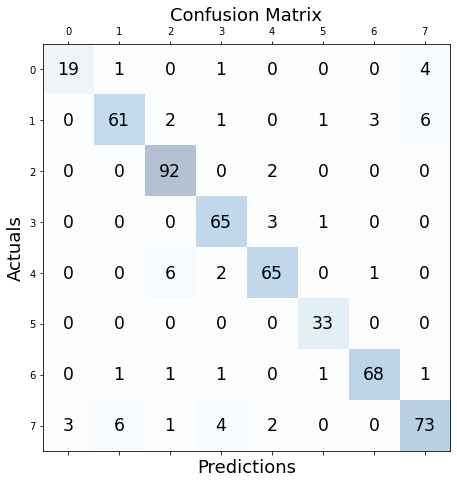

In [25]:
metrics = model.evaluate(validation_set, return_dict=True)
print(metrics)

DATASET_EVAL = validation_set
labels = np.concatenate([y for x, y in DATASET_EVAL], axis=0) 
predictions = model.predict(validation_set) 

assert len(labels) == len(predictions)

# Compute the confusion matrix
cm = confusion_matrix(np.argmax(labels, axis=-1), np.argmax(predictions, axis=-1))

# Compute the classification metrics
accuracy = accuracy_score(np.argmax(labels, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(labels, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(labels, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(labels, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1_classes = f1_score(np.argmax(labels, axis=-1), np.argmax(predictions, axis=-1), average=None)

print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))
print('F1 (per class):')
print(f1_classes)

print('WORST CLASS: Species:', np.argmin(f1_classes)+1)

# Plot the confusion matrix
ig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(cm, cmap=plt.cm.Blues, alpha=0.3)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(x=j, y=i,s=cm[i, j], va='center', ha='center', size='xx-large')

        
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()